In today's post, we will take a look at adversarial attacks. Adversarial attacks have become an active field of research in the deep learning community, for reasons quite similar to why information security and cryptography are important fields in the general context of computer science. Adversarial examples are to deep learning models what viruses and malware are for computers. Of course, as is the case with any metaphor or parallel examples, these are simplifications to guide our intuition, not a robust one-to-one correspondence. 

This notebook was heavily adapted from the [PyTorch official tutorial](https://pytorch.org/tutorials/beginner/fgsm_tutorial.html) on adversarial example generation. I basically borrowed the model and weights from the tutorial to avoid having to create and train a model from scratch. Let's get started!

# Concept

Before we jump into the implementation, let's briefly go over what adversarial attacks are. In particular, we will be looking at one of the earliest methods of adversarial attack, known as the fast gradient sign method, or FGSM for short. FGSM was introduced in the paper [Explaining and Harnesing Adversarial Examples](https://arxiv.org/abs/1412.6572), and has gained a lot of traction since. 

The paper isn't the easiest, but it's also not too difficult to follow. Here, I will try to present some details from the paper while not deviating too much from the bigger picture. 

## Perturbation

Given a simple linear classifier

$$
w^\top x
$$

where $w$ is the weight matrix, we can think of an adversarial example that contains a small, non-perceivable perturbation to the input. Let's denote the perturbation as $\eta$.

$$
\tilde{x} = x + \eta
$$

Then, the logits of the classier would be 

$$
\begin{align}
w^\top \tilde{x}
&= w^\top (x + \eta) \\
&= w^\top x + w^\top \eta
\end{align}
$$

This means that, given a small perturbation $\eta$, the actual effect of the perturbation on the logits of the classifier is given by $w^\top \eta$. The underlying idea behind FGSM is that we can find some $\eta$ that causes a change that is non-perceivable and ostensibly innocuous to the human eye, yet destructive and adverse enough for the classifier to the extent that its predictions are no longer accurate. 

Let's put this into context by considering an example. Say we have some image classifier that receives RBG images as input. Typical RGB images have integer pixel values ranging from 0 to 255. These values are typically preprocessed through division by 255. Hence, the precision of data is limited by this eight-bit bottleneck. This means that, for perturbations below $1/255$, we should not expect the classifier to output a different prediction. In other words, the addition of $w^\top \eta$ should not cause the model to behave any different in the absence of any perturbation. 

An adversarial example is one that which maximizes the value of $w^\top \eta$ to sway the model into making a wrong prediction. Of course, there is a constraint to be placed on $\eta$; otherwise, we could just apply a huge perturbation to the input image, but then the perturbation could be visible enough to change the ground truth label. Hence, we apply a constraint such that

$$
\lVert \eta \rVert_{\infty} \leq \epsilon
$$

The infinity norm is defined as 

$$
\lVert A \rVert_{\infty} = \max_{1 \leq i \leq m} \sum_{j=1}^{n} \lvert a_{ij} \rvert
$$

which, more simply put, means the largest absolute value of the element in the matrix or vector. In this context, it means that the largest magnitude of the element in $\eta$ does not exceed the precision constraint $\epsilon$. 

Then, Goodfellow proceeds to explain the maximum bounds of this perturbation. Namely, given that

$$
\eta = \epsilon \cdot \text{sign}(w)
$$

the maximum bound of the change in activation can be written as 

$$
\begin{align}
w^\top \eta 
&= \epsilon \cdot w^\top \text{sign}(w) \\
&= \epsilon \lVert w \rVert_1 \\
&= \epsilon m n
\end{align}
$$

where the average magnitude of an element of $w$ is given by $m$, and $w \in \mathbb{R}^n$. 

This tells us that the change in activation given by the perturbation increases linearly with respect to $n$, or the dimension. In other words, in sufficiently high-dimensional contexts, we can expect even a small perturbation capped at $\epsilon$ to produce a perturbation big enough to render the model susceptible to an adversarial attack. Such perturbed examples as referred to as adversarial examples. 

## Gradient

The equations above demonstrated that the degree of perturbation increases as dimensionality increases. In other words, we established that creating adversarial examples are possible via infinitesimal perturbations. In this section, let's dive into the specifics of FGSM. 

The idea behind FGSM is surprisingly simple: we do opposite of the typical gradient descent in order to maximize the loss, since confusing the model is the end goal of adversarial attack. Therefore, we consider $x$, the model's input, to be a trainable parameter. Then, we add the gradient to its original input variable to create a perturbation. Mathematically, this can be expressed as follows:

$$
\eta = \epsilon \cdot \text{sign}(\nabla_{x} J(w, x, y))
$$

where $J$ represents the cost function. Then, we can create an adversarial example via

$$
\tilde{x} = x + \epsilon \cdot \text{sign}(\nabla_{x} J(w, x, y))
$$

This is the crux of the fast gradient sign method: we use the sign of the gradient, multiply it by some small value, and add that perturbation to the original input to create an adversarial example. 

One way to look at this is in terms of first-order approximation. Recall that 

$$
f(\tilde{x}) \simeq f(x) + (\tilde{x} - x)^\top \nabla_x f(x)
$$

In this context, we can consider $f$ to be the cost function $J$, which then turns into

$$
J(w, \tilde{x}) = J(x, w) + (\tilde{x} - x)^\top \nabla_x J(w, x)
$$

Then, the goal of an adversarial attack is to maximize the second term in the addition. Since there is an infinity norm constraint on the perturbation, namely

$$
\lVert \tilde{x} - x \rVert_\infty \leq \epsilon
$$

with some thinking we can convince ourselves that the perturbed example that maximizes the loss function is given by 


$$
\tilde{x} = x + \epsilon \cdot \text{sign}(\nabla_{x} J(w, x, y))
$$

# Implementation

Let's import some modules, download and process MNIST data, and declare a model on which to perform an adversarial attack. These are all routine operations, so I'll drop a lot of the explanation. 

## Setup

In [31]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format = 'svg'

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

Below is a tody convolutional neural network model designed to classify MNIST handwritten digits.

In [2]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 10, kernel_size=5)
        self.conv2 = nn.Conv2d(10, 20, kernel_size=5)
        self.conv2_drop = nn.Dropout2d()
        self.fc1 = nn.Linear(320, 50)
        self.fc2 = nn.Linear(50, 10)

    def forward(self, x):
        x = F.relu(F.max_pool2d(self.conv1(x), 2))
        x = F.relu(F.max_pool2d(self.conv2_drop(self.conv2(x)), 2))
        x = x.view(-1, 320)
        x = F.relu(self.fc1(x))
        x = F.dropout(x, training=self.training)
        x = self.fc2(x)
        return F.log_softmax(x, dim=1)

We load the model and put it into evaluation mode, since we won't be updating the weights of the model.

In [3]:
model = Net().to(device)
model.load_state_dict(torch.load("./data/lenet_mnist_model.pth", map_location="cpu"))
model.eval()

Net(
  (conv1): Conv2d(1, 10, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(10, 20, kernel_size=(5, 5), stride=(1, 1))
  (conv2_drop): Dropout2d(p=0.5, inplace=False)
  (fc1): Linear(in_features=320, out_features=50, bias=True)
  (fc2): Linear(in_features=50, out_features=10, bias=True)
)

Since we want to create perturbations for each image, we need to set the batch size to be one. 

In [4]:
test_loader = torch.utils.data.DataLoader(
    datasets.MNIST(
        "./data",
        train=False,
        download=True,
        transform=transforms.Compose([transforms.ToTensor(),]),
    ),
    batch_size=1,
    shuffle=True,
)

## Fast Gradient Sign Method

Now, let's actually implement FGSM. The function below takes an image and some small value epsilon as input. Using the sign of the gradient, we then create a small perturbation to which we add to the image. Note that we clamp the value of the perturbed image to have values between 0 and 1, since that is the valid range for a normalized pixel value.

In [5]:
def fgsm_attack(image, epsilon):
    perturbed_image = image + epsilon * image.grad.data.sign()
    perturbed_image = torch.clamp(perturbed_image, 0, 1)
    return perturbed_image

Next, we define a custom loop function that examines each image in the test loader and generates predictions. If the prediction is wrong in the first place without any perturbation, we move on; the point of an adversarial attack is to create an adversarial example from an innocuous example that the model would have otherwise predicted correctly. 

A key implementation detail is the fact that we set the `requires_grad` property of the image to be true so that we can later obtain the gradients for the input. We then back propagate on the loss to obtain the gradient values, then create a perturbed image using the `fgsm_attack` function we have defined above. For demonstration purposes, we store the first few successful adversarial examples in a list. We also calculate the accuracy of the model and return that value as well.

In [6]:
def test(model, test_loader, epsilon, device, num_display=5):
    
    num_correct = 0
    adv_examples = []
    
    for image, label in test_loader:
        image = image.to(device)
        label = label.to(device)
        image.requires_grad = True

        output = model(image)
        _, init_pred = output.max(dim=1)

        if init_pred.item() != label.item():
            continue

        loss = F.nll_loss(output, label)
        model.zero_grad()
        loss.backward()

        perturbed_image = fgsm_attack(image, epsilon)
        perturbed_output = model(perturbed_image)
        _, perturbed_pred = perturbed_output.max(dim=1)

        if perturbed_pred.item() == label.item():
            num_correct += 1
        elif len(adv_examples) < num_display:
            adv_examples.append(
                (
                    label.item(), 
                    perturbed_pred.item(), 
                    perturbed_image.squeeze().detach().cpu().numpy()
                )
            )
    
    accuracy = num_correct / len(test_loader)
    print(f"Epsilon: {epsilon}, Accuracy: {accuracy:.3f}")
    
    return accuracy, adv_examples

Now we're done! Let's define some epsilon values and run the test. Intuitively, we would expect the accuracy of the model to go down as the epsilon value increases; a higher epsilon value corresponds to a larger perturbation, which could more adversely impact the model.

In [7]:
num_display = 5
accuracies = []
all_adv_examples = []
epsilons = [.05, .1, .15, .2, .25, .3]

for epsilon in epsilons:
    accuracy, adv_examples = test(model, test_loader, epsilon, device, num_display)
    accuracies.append(accuracy)
    all_adv_examples.append(adv_examples)

Epsilon: 0.05, Accuracy: 0.943
Epsilon: 0.1, Accuracy: 0.851
Epsilon: 0.15, Accuracy: 0.683
Epsilon: 0.2, Accuracy: 0.430
Epsilon: 0.25, Accuracy: 0.208
Epsilon: 0.3, Accuracy: 0.087


Through the print statements, we see that our initial predictions are indeed correct. A simple visualization also helps us see how quickly this drop in accuracy happens. 

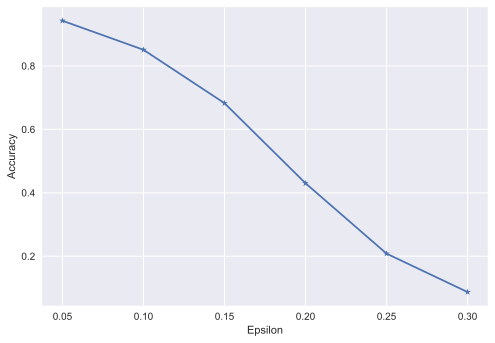

In [40]:
plt.style.use("seaborn")
plt.plot(epsilons, accuracies, "*-")
plt.xlabel("Epsilon")
plt.ylabel("Accuracy")
plt.show()

Now comes the fun part: showing the adversarial examples. It might seem like there is a lot going on in the code block below, but really, a lot of it is just some grunt work I've done to display the examples in a nice grid with headers and labels. Let's take a look at the adversarial examples that have been generated for each value of epsilon.

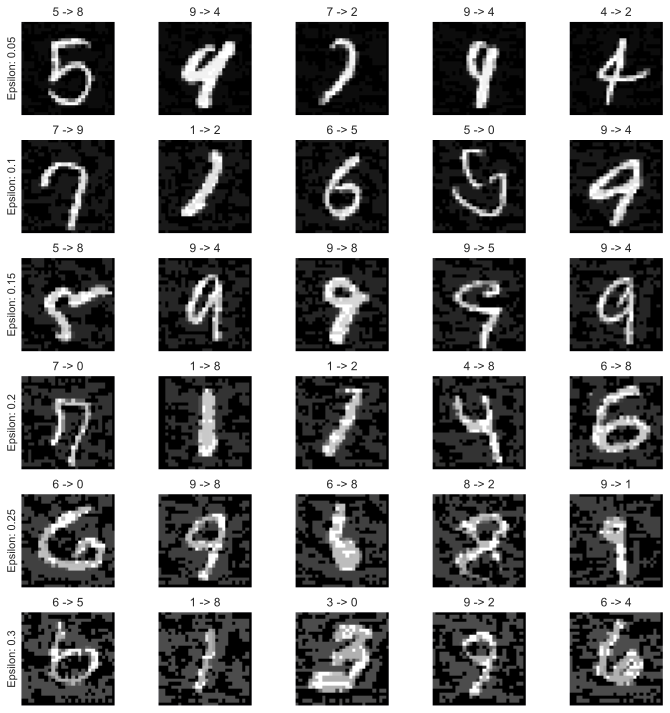

In [42]:
def clean_axis(axis):
    axis.set_xticks([])
    axis.set_yticks([])
    axis.set_xticklabels([])
    axis.set_yticklabels([])

    
nrows = len(epsilons)
ncols = num_display

fig, ax = plt.subplots(6, 5, figsize=(10, 10))

for row in range(nrows):
    for col in range(ncols):
        label, perturbed_pred, perturbed_image = all_adv_examples[row][col]
        axis = ax[row, col]
        axis.imshow(perturbed_image, cmap="gray")
        axis.set_title(f"{label} -> {perturbed_pred}")
        clean_axis(axis)
        if col == 0:
            axis.set_ylabel(f"Epsilon: {epsilons[row]}")
plt.tight_layout()
plt.show()

It's really interesting to see how our model could confuse some of these examples. Granted, not all handwritings are obvious, and there are definitely ones that could be tricky. However, as the value of epsilon goes up, it appears that even obvious digits can be mistaken by the model to be some other digit that bears no resemblance. This is adversarial attack in action. 

# Conclusion

In today's post, we discussed adversarial attacks, specifically the fast gradient sign method. Although I tried to get a little technical by going through each equation in the original paper (and even then, I skipped a few), the overarching idea behind FGSM, as I understand it, is surprisingly simple: neural networks are more linear than we think, and we can create gradient-based, small perturbations that can maximize the loss, thus disrupting the model's behavior. 

Since FGSM, other more advanced attack methods have been introduced. Nowadays, building robust models that can withstand such attacks are becoming increasingly important. FGSM is an example of a white-box attack method: in this case, we had full access to the gradients and parameters of the model. However, there are also black-box attacks that are performed by an attacker in the absence of knowledge about the model's parameters. Perhaps we will discuss more of these in the future. 

I hope you've enjoyed reading this post. See you in the next one.